# Double-bracket Gradient Descent Stratgies
This notebook demonstrates the gradient descent strategies for double-bracket rotations. The mehods uses a numerical method to find the gradient of the cost function with respect to the diagonal operator, and thereby variate the diagonal operator of the rotation. 

Finding the gradient requires the parameterization of the diagonal operator, and there are two ways of doing so:

1. Pauli-basis: $D(B,J)= \sum B_i Z_i + \sum J_{ij}Z_iZ_j + ...$
2. Computational-basis: $D(A)=\sum A_i|i\rangle\langle i|$

In [1]:
from qibo.models.dbi.double_bracket import *
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_dbr_strategies import *
import numpy as np
from qibo import set_backend, hamiltonians
from qibo.hamiltonians import Hamiltonian
from qibo.quantum_info import random_hermitian
import matplotlib.pyplot as plt

In [2]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)
    
def s_hist_to_plot(s_hist):
    # convert list of step durations taken to plotable
    s_plot = [0] * len(s_hist)
    for i in range(len(s_hist)):
        if i != 0:
            s_plot[i] = s_plot[i-1] + s_hist[i]
    return s_plot

# Random Hamiltonian

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.9|INFO|2024-05-29 14:29:00]: Using qibojit (numba) backend on /CPU:0


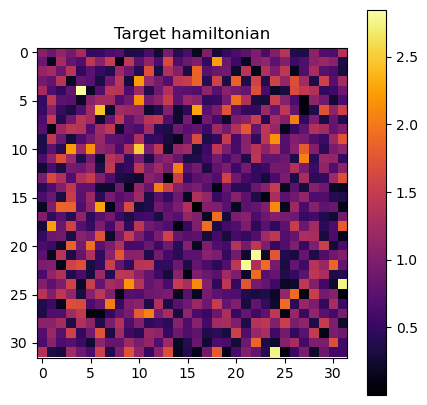

In [3]:
# set the qibo backend (we suggest qibojit if N >= 20)
set_backend("qibojit", platform="numba")

# hamiltonian parameters
nqubits = 5
seed = 10

# define the hamiltonian
h0 = random_hermitian(2**nqubits, seed=seed)
dbi = DoubleBracketIteration(
    Hamiltonian(nqubits, h0),
    mode=DoubleBracketGeneratorType.single_commutator,
    scheduling=DoubleBracketScheduling.hyperopt,
    cost=DoubleBracketCostFunction.off_diagonal_norm
)
# vosualize the matrix
visualize_matrix(dbi.h.matrix, title="Target hamiltonian")

Then we set up the required parameters for gradient descent.

[Qibo 0.2.9|WARNING|2024-05-29 14:29:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/qibo/models/dbi/utils.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i, i] = params[i]
/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex value

Text(0.5, 1.0, 'Diagonal entries of $D$')

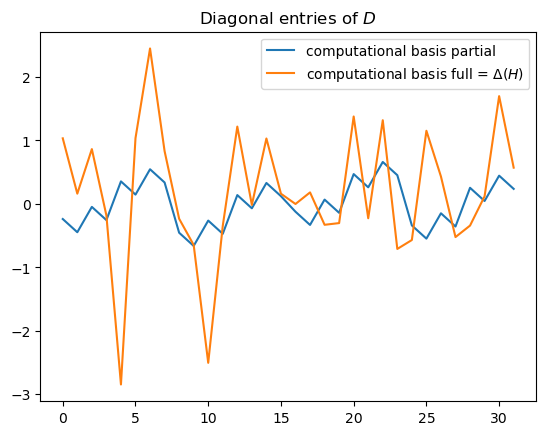

In [4]:
# Pauli-basis
pauli_operator_dict = generate_pauli_operator_dict(nqubits)
pauli_operators = list(pauli_operator_dict.values())
# let initial d be approximation of $\Delta(H)
d_coef_pauli = decompose_into_Pauli_basis(dbi.diagonal_h_matrix, pauli_operators=pauli_operators)
d_pauli = sum([d_coef_pauli[i]*pauli_operators[i] for i in range(nqubits)])

# Computational basis
d_coef_computational_partial = d_pauli.diagonal()
d_coef_computational_full = dbi.diagonal_h_matrix.diagonal()
d_computational_partial = params_to_diagonal_operator(d_coef_computational_partial, nqubits, ParameterizationTypes.computational, normalize=False)
d_computational_full = params_to_diagonal_operator(d_coef_computational_full, nqubits, ParameterizationTypes.computational, normalize=False)

plt.plot(d_coef_computational_partial, label="computational basis partial")
plt.plot(d_coef_computational_full, label=r"computational basis full = $\Delta(H)$")
plt.legend()
plt.title(r"Diagonal entries of $D$")


Now we want to compare 3 scenarios:

1. Pauli-basis: an approximation to the diagonal of $H$
2. Computational-partial: same as 1. in the computational basis.
3. Computational-full: a full parameterization of the diagonal of $H$ in the computational basis.

In [5]:
# 1. Pauli-basis
NSTEPS = 10
dbi_pauli = deepcopy(dbi)
loss_hist_pauli, d_params_hist_pauli, s_hist_pauli = gradient_descent(dbi_pauli, NSTEPS, d_coef_pauli, ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

100%|██████████| 500/500 [00:00<00:00, 701.00trial/s, best loss: 12.440033389264197] 


In [6]:
# 2. Computational_partial
dbi_computational_partial = deepcopy(dbi)
loss_hist_computational_partial, d_params_hist_computational_partiali, s_computational_partial = gradient_descent(dbi_computational_partial, NSTEPS, d_coef_computational_partial, ParameterizationTypes.computational)

100%|██████████| 500/500 [00:00<00:00, 726.24trial/s, best loss: 11.029509543631354] 


In [7]:
# 3. Computational_full
dbi_computational_full = deepcopy(dbi)
loss_hist_computational_full, d_params_hist_computational_full, s_computational_full = gradient_descent(dbi_computational_full, NSTEPS, d_coef_computational_full, ParameterizationTypes.computational)

100%|██████████| 500/500 [00:00<00:00, 701.69trial/s, best loss: 17.469857523504825] 


In [8]:
s_plot_pauli = s_hist_to_plot(s_hist_pauli)
s_plot_computational_partial = s_hist_to_plot(s_computational_partial)
s_plot_computational_full = s_hist_to_plot(s_computational_full)

Text(0.5, 0, 's')

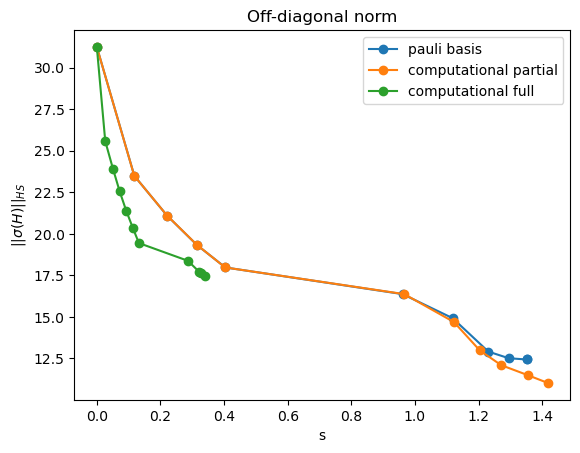

In [9]:
plt.plot(s_plot_pauli, loss_hist_pauli, label="pauli basis", marker="o")
plt.plot(s_plot_computational_partial, loss_hist_computational_partial, label="computational partial", marker="o")
plt.plot(s_plot_computational_full, loss_hist_computational_full, label="computational full", marker="o")
plt.legend()
plt.title("Off-diagonal norm")
plt.ylabel(r"$||\sigma(H)||_{HS}$")
plt.xlabel("s")


# TFIM

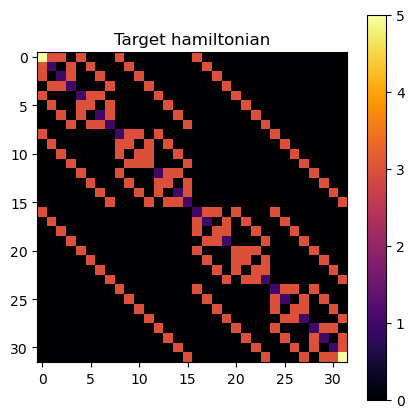

In [10]:
# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)
dbi = DoubleBracketIteration(
    h,
    mode=DoubleBracketGeneratorType.single_commutator,
    scheduling=DoubleBracketScheduling.hyperopt
)
# vosualize the matrix
visualize_matrix(dbi.h.matrix, title="Target hamiltonian")

[Qibo 0.2.9|WARNING|2024-05-29 14:29:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-05-29 14:29:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Text(0.5, 1.0, 'Diagonal entries of $D$')

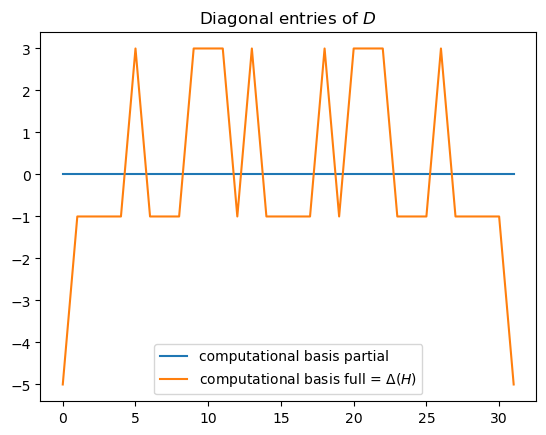

In [11]:
# Pauli-basis
pauli_operator_dict = generate_pauli_operator_dict(nqubits)
pauli_operators = list(pauli_operator_dict.values())
# let initial d be approximation of $\Delta(H)
d_coef_pauli = decompose_into_Pauli_basis(dbi.diagonal_h_matrix, pauli_operators=pauli_operators)
d_pauli = sum([d_coef_pauli[i]*pauli_operators[i] for i in range(nqubits)])

# Computational basis
d_coef_computational_partial = d_pauli.diagonal()
d_coef_computational_full = dbi.diagonal_h_matrix.diagonal()
d_computational_partial = params_to_diagonal_operator(d_coef_computational_partial, nqubits, ParameterizationTypes.computational, normalize=False)
d_computational_full = params_to_diagonal_operator(d_coef_computational_full, nqubits, ParameterizationTypes.computational, normalize=False)

plt.plot(d_coef_computational_partial, label="computational basis partial")
plt.plot(d_coef_computational_full, label=r"computational basis full = $\Delta(H)$")
plt.legend()
plt.title(r"Diagonal entries of $D$")


In [12]:
# 1. Pauli-basis
NSTEPS = 10
dbi_pauli = deepcopy(dbi)
loss_hist_pauli, d_params_hist_pauli, s_hist_pauli = gradient_descent(dbi_pauli, NSTEPS, d_coef_pauli, ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

100%|██████████| 500/500 [00:00<00:00, 719.34trial/s, best loss: 8.985880617807844] 


In [13]:
# 2. Computational_partial
dbi_computational_partial = deepcopy(dbi)
loss_hist_computational_partial, d_params_hist_computational_partiali, s_computational_partial = gradient_descent(dbi_computational_partial, NSTEPS, d_coef_computational_partial, ParameterizationTypes.computational)

100%|██████████| 500/500 [00:00<00:00, 733.76trial/s, best loss: 21.152877390520732] 


In [14]:
# 3. Computational_full
dbi_computational_full = deepcopy(dbi)
loss_hist_computational_full, d_params_hist_computational_full, s_computational_full = gradient_descent(dbi_computational_full, NSTEPS, d_coef_computational_full, ParameterizationTypes.computational)

100%|██████████| 500/500 [00:00<00:00, 713.48trial/s, best loss: 21.15289385103726]  


In [15]:
s_plot_pauli = s_hist_to_plot(s_hist_pauli)
s_plot_computational_partial = s_hist_to_plot(s_computational_partial)
s_plot_computational_full = s_hist_to_plot(s_computational_full)

Text(0.5, 0, 's')

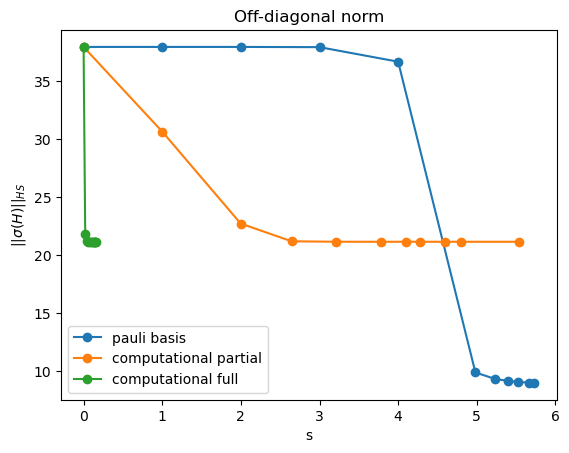

In [16]:
plt.plot(s_plot_pauli, loss_hist_pauli, label="pauli basis", marker="o")
plt.plot(s_plot_computational_partial, loss_hist_computational_partial, label="computational partial", marker="o")
plt.plot(s_plot_computational_full, loss_hist_computational_full, label="computational full", marker="o")
plt.legend()
plt.title("Off-diagonal norm")
plt.ylabel(r"$||\sigma(H)||_{HS}$")
plt.xlabel("s")


After changing the cost function and scheduling method, we notice that quite consistently, the Pauli-based parameterization diagonalizes the hamiltonian the best, and for the first few iterations, the Computational-based partial (same initial operator as Pauli) performs very similarly, and diverges later on.